In [1]:
import re
import os
import random
import requests
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


random.seed(0)

SOURCE_IN_IMAGES_DIR = "/data/27kpng/val_images/image" 
SELECTED_IN_IMAGES_DIR = "data/27kpng/watermarked_images"

SOURCE_CLEAN_IMAGES_DIR = "/data/27kpng/val_images/target"
SELECTED_CLEAN_IMAGES_DIR = "data/27kpng/clean_images"

PROCESSED_IMAGES_RIRCI_DIR = "data/27kpng/rirci"
PROCESSED_IMAGES_SPLITNET_DIR = "data/27kpng/splitnet"

In [2]:
from torchvision import transforms


preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Resize((480, 640)),
])

def copy_n_random_files(source, target, n=30):
    if not os.path.isdir(source):
        raise ValueError(f"Source directory does not exist: {source}")

    all_files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    
    if len(all_files) < n:
        raise ValueError(f"Not enough files in source directory. Requested {n}, found {len(all_files)}")

    selected_files = random.sample(all_files, n)

    if os.path.exists(target):
        shutil.rmtree(target)
    os.makedirs(target)

    for filename in selected_files:
        shutil.copy2(os.path.join(source, filename), target)

    return selected_files

def open_and_resize(image_path):
    im = Image.open(image_path).convert('RGB')
    return preprocess(im)


def get_clean_images(source, target, filenames):
    if not os.path.isdir(source):
        raise ValueError(f"Source directory does not exist: {source}")

    if os.path.exists(target):
        shutil.rmtree(target)
    os.makedirs(target)

    copied_files = []
    for filename in filenames:
        src_path = os.path.join(source, filename)
        target_path = os.path.join(target, filename)
        if os.path.isfile(src_path):
            image = open_and_resize(src_path)
            image.save(target_path, quality=95)
            copied_files.append(filename)
    
    return copied_files

In [3]:
selected_watermarked_images = copy_n_random_files(SOURCE_IN_IMAGES_DIR, SELECTED_IN_IMAGES_DIR)
len(selected_watermarked_images)

30

In [4]:
selected_clean_images = get_clean_images(SOURCE_CLEAN_IMAGES_DIR, SELECTED_CLEAN_IMAGES_DIR, selected_watermarked_images)
len(selected_clean_images)

30

### RIRCI inference

In [5]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Available GPUs: {device_count}")
    
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No CUDA devices found.")

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print('Using: ', device)

Available GPUs: 4
GPU 0: NVIDIA A100 80GB PCIe
GPU 1: NVIDIA A100 80GB PCIe
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100 80GB PCIe
Using:  cuda:3


In [6]:
from lib.models.rirci import RIRCIModel 
from lib.models.inference_wrapper import InferenceWrapper


def load_model_from_checkpoint(checkpoint_path):
    model = RIRCIModel(simple=True).to(device)
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model = model.to(device)
    model.eval()

    return InferenceWrapper(model)


model = load_model_from_checkpoint(
    '/app/checkpoints/RIRCIModel-2025-05-10-090853/best_model.pth',
)

/tmp/ipykernel_3559/2975820283.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


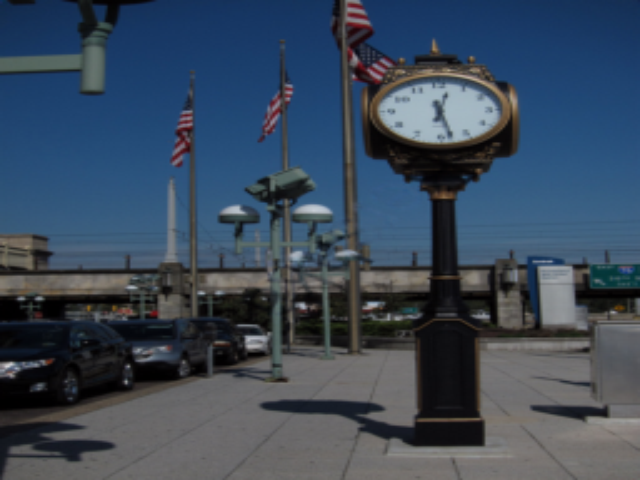

In [7]:
test_image = os.path.join(SELECTED_IN_IMAGES_DIR, selected_watermarked_images[1])
test_target = os.path.join(SELECTED_CLEAN_IMAGES_DIR, selected_watermarked_images[1])

image = preprocess(model.enhance_image(device, test_image, norm=True))
image

In [8]:
def get_rirci_images(model, device):
    if not os.path.isdir(SELECTED_IN_IMAGES_DIR):
        raise ValueError(f"Source directory does not exist: {SELECTED_IN_IMAGES_DIR}")

    if os.path.exists(PROCESSED_IMAGES_RIRCI_DIR):
        shutil.rmtree(PROCESSED_IMAGES_RIRCI_DIR)
    os.makedirs(PROCESSED_IMAGES_RIRCI_DIR)

    processed_files = []
    for filename in os.listdir(SELECTED_IN_IMAGES_DIR):
        src_path = os.path.join(SELECTED_IN_IMAGES_DIR, filename)
        if os.path.isfile(src_path):
            image = preprocess(model.enhance_image(device, src_path, norm=True))
            image.save(os.path.join(PROCESSED_IMAGES_RIRCI_DIR, filename), quality=95)
            processed_files.append(filename)

    return processed_files

processed = get_rirci_images(model, device)
len(processed)

30

### SplitNet inference

In [9]:
# ! git clone https://github.com/vinthony/deep-blind-watermark-removal.git # get code from github
# ! gdown https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc # get pretrained model
# ! mv 27kpng_model_best.pth.tar deep-blind-watermark-removal/

In [10]:
import sys

SPLITNET_DIR = 'deep-blind-watermark-removal'

sys.path.append(SPLITNET_DIR)
sys.path.insert(0, SPLITNET_DIR)

from scripts.utils.imutils import im_to_numpy
import scripts.models as models
import scripts.datasets as datasets

resume_path = f'{SPLITNET_DIR}/27kpng_model_best.pth.tar' # path of pretrained model

In [11]:
model = models.__dict__['vvv4n']().to(device)
model.load_state_dict(torch.load(resume_path)['state_dict'])
model.eval()

model = InferenceWrapper(model)
print('loaded_model')

/opt/conda/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_3559/2929942248.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

loaded_model


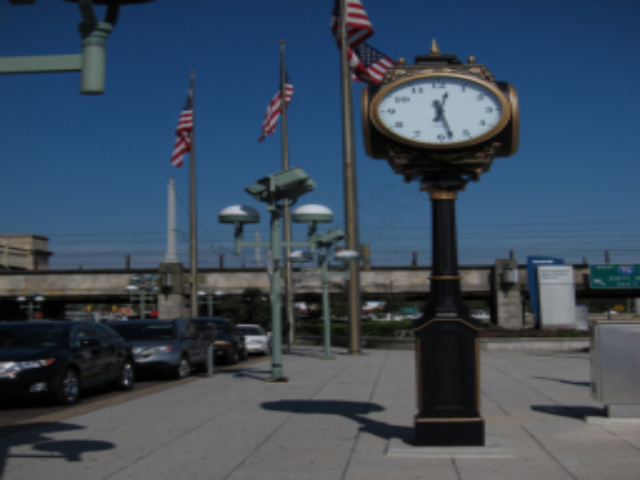

In [12]:
image = preprocess(model.enhance_image(device, test_image, norm=False))
image

In [13]:
def get_splitnet_images(model, device):
    if not os.path.isdir(SELECTED_IN_IMAGES_DIR):
        raise ValueError(f"Source directory does not exist: {SELECTED_IN_IMAGES_DIR}")

    if os.path.exists(PROCESSED_IMAGES_SPLITNET_DIR):
        shutil.rmtree(PROCESSED_IMAGES_SPLITNET_DIR)
    os.makedirs(PROCESSED_IMAGES_SPLITNET_DIR)

    processed_files = []
    for filename in os.listdir(SELECTED_IN_IMAGES_DIR):
        src_path = os.path.join(SELECTED_IN_IMAGES_DIR, filename)
        if os.path.isfile(src_path):
            image = preprocess(model.enhance_image(device, src_path, norm=False))
            image.save(os.path.join(PROCESSED_IMAGES_SPLITNET_DIR, filename), quality=95)
            processed_files.append(filename)

    return processed_files

processed = get_splitnet_images(model, device)
len(processed)

30

In [14]:
def make_experiment_grid(images):
    n_0, n_a, n_b = 15, 15, 15

    n_0_images = images[:n_0]
    n_ab_images = images[n_0:]

    left_images = []
    right_images = []
    left_labels = []
    right_labels = []
    
    # A vs B
    for image in n_0_images:
        rirci = os.path.join(PROCESSED_IMAGES_RIRCI_DIR, image)
        splitnet = os.path.join(PROCESSED_IMAGES_SPLITNET_DIR, image)

        if (left_label := random.choice(['rirci', 'splitnet'])) == 'rirci':
            left_labels.append('rirci')
            right_labels.append('splitnet')
            left_images.append(rirci)
            right_images.append(splitnet)
        else:
            left_labels.append('splitnet')
            right_labels.append('rirci')
            left_images.append(splitnet)
            right_images.append(rirci)

    # A vs 0
    for image in n_ab_images:
        rirci = os.path.join(PROCESSED_IMAGES_RIRCI_DIR, image)
        clean = os.path.join(SELECTED_CLEAN_IMAGES_DIR, image)

        if (left_label := random.choice(['rirci', 'clean'])) == 'rirci':
            left_labels.append('rirci')
            right_labels.append('clean')
            left_images.append(rirci)
            right_images.append(clean)
        else:
            left_labels.append('clean')
            right_labels.append('rirci')
            left_images.append(clean)
            right_images.append(rirci)

    # B vs 0
    for image in n_ab_images:
        splitnet = os.path.join(PROCESSED_IMAGES_SPLITNET_DIR, image)
        clean = os.path.join(SELECTED_CLEAN_IMAGES_DIR, image)

        if (left_label := random.choice(['splitnet', 'clean'])) == 'splitnet':
            left_labels.append('splitnet')
            right_labels.append('clean')
            left_images.append(splitnet)
            right_images.append(clean)
        else:
            left_labels.append('clean')
            right_labels.append('splitnet')
            left_images.append(clean)
            right_images.append(splitnet)
        

    return pd.DataFrame({'left_image': left_images, 'right_image': right_images,
                         'left_label': left_labels, 'right_label': right_labels}).sample(frac=1.).reset_index(drop=True)
    

grid = make_experiment_grid(processed)
grid.head()

,left_image,right_image,left_label,right_label
0,data/27kpng/clean_images/COCO_val2014_00000043...,data/27kpng/rirci/COCO_val2014_000000431401-Cl...,clean,rirci
1,data/27kpng/rirci/COCO_val2014_000000472399-Ba...,data/27kpng/clean_images/COCO_val2014_00000047...,rirci,clean
2,data/27kpng/rirci/COCO_val2014_000000191533-Be...,data/27kpng/clean_images/COCO_val2014_00000019...,rirci,clean
3,data/27kpng/clean_images/COCO_val2014_00000020...,data/27kpng/splitnet/COCO_val2014_000000204100...,clean,splitnet
4,data/27kpng/splitnet/COCO_val2014_000000370208...,data/27kpng/rirci/COCO_val2014_000000370208-Bu...,splitnet,rirci


In [15]:
grid.to_csv('data/27kpng/experiment_grid.csv', index=False)